# Chapter 5: Field data study Rockeskyller Kopf
# Conventional Inversions


<div class="alert alert-success">
    
This Notebook only reproduces the results of ``Sata/Rockeskyll/Res_Conventional``. Visualization in Notebook 5.4.

In [1]:
# %% IMPORTS
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import pygimli           as pg
import pygimli.meshtools as mt
import cmasher           as cmr
import functools
import warnings

from pygimli.viewer             import pv
from pygimli.physics            import ert
from scipy.interpolate          import griddata
from AZ_pygimli_3DTopo          import *
from PlotFunctions_Ch5          import *
from datetime                   import datetime

warnings.filterwarnings("ignore")

### Parameters and names

In [2]:
fig_dir = 'C:/Users/azieg/Desktop/GIT_repositories/APG-MSc-Project-Ziegon/Figures/Ch-5/'
fn_dir  = 'C:/Users/azieg/Desktop/GIT_repositories/APG-MSc-Project-Ziegon/Data/Rockeskyll/'

fn_mesh = 'invmesh.bms'

fn_magnetic = 'Magnetic_data_corrected.csv'

fn_2d1 ='ert_data_2d_1'
fn_2d2 ='ert_data_2d_2'
fn_2d3 ='ert_data_2d_3'
fn_2d4 ='ert_data_2d_4'
fn_all = 'ert_data_rockes_all'
geo1 ='Geo/2023_ERTL1_Locations.csv'
geo2 ='Geo/2023_ERTL2_Locations.csv'
geo3 ='Geo/2023_ERTL3_Locations.csv'
geo4 ='Geo/2023_ERTL4_Locations.csv'

# PARAMETERS (based on Boxberg 2011)
F = 48487.4   # Median field intensity in nT

n_lines = 4 # number of lines
idx_list = [0, 2055, 4134, 5906, 7694] # for Pseudosection display

SEED = 420 # Random seed to ensure reproduceability

# Plotting
c_ert = 'gnuplot'
c_mag = cmr.tropical
lim_pseudos = [18,180]

### Importing Magnetic Data and Geometry

In [3]:
# %% READING DATA CSV-FILE
df = pd.read_csv(fn_dir+fn_magnetic, delimiter=',', decimal='.')
d_obs = df['F'].to_numpy()-F                                           # Total Field Anomaly numpy array
pnts = np.array([[df['X'][i], df['Y'][i], df['Z'][i]] for i in range(len(df))])

### Importing ERT Geometry

In [4]:
df1 = pd.read_csv(fn_dir+geo1, delimiter=',', decimal='.')
p1 = np.array([[df1['X'][i], df1['Y'][i], df1['Z'][i]] for i in range(len(df1))])

df2 = pd.read_csv(fn_dir+geo2, delimiter=',', decimal='.')
p2 = np.array([[df2['X'][i], df2['Y'][i], df2['Z'][i]] for i in range(len(df2))])

df3 = pd.read_csv(fn_dir+geo3, delimiter=',', decimal='.')
p3 = np.array([[df3['X'][i], df3['Y'][i], df3['Z'][i]] for i in range(len(df3))])

df4 = pd.read_csv(fn_dir+geo4, delimiter=',', decimal='.')
p4 = np.array([[df4['X'][i], df4['Y'][i], df4['Z'][i]] for i in range(len(df4))])

### Importing ERT Data

Text(0.5, 1.0, 'ERT Data')

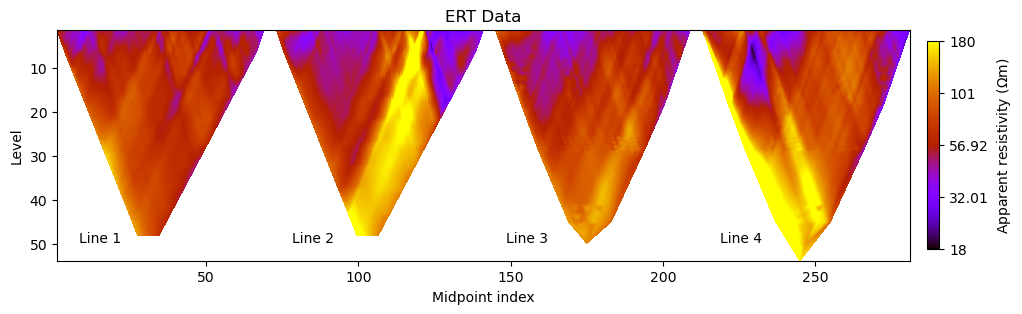

In [5]:
d_ert    = ert.load(fn_dir+fn_all)
d_ert2d1 = ert.load(fn_dir+fn_2d1)
d_ert2d2 = ert.load(fn_dir+fn_2d2)
d_ert2d3 = ert.load(fn_dir+fn_2d3)
d_ert2d4 = ert.load(fn_dir+fn_2d4)


# PLOT PSEUDOSECTIONS
%matplotlib inline
fig, ax = plt.subplots(figsize=(11,3))
showPseudosections(d_ert, d_ert['rhoa'].array(), idx_list, 4, ax=ax, clim=lim_pseudos, cmap=c_ert)
ax.set_title('ERT Data')

## Load Mesh

In [6]:
mesh = pg.load(fn_dir+fn_mesh)
mesh

Mesh: Nodes: 8381 Cells: 40005 Boundaries: 83717

### Magnetics 3D inversion

In [11]:
# Setup Inversion Manager
MAG, d_mag, relError = createMagManager(mesh, df)

# Create Starting Model
startModel = pg.Vector(mesh.cellCount(), 1e-4) # surrounding rock has susceptibility of around 0.00001

   0%|          |0/294 [00:00 < ?]

In [12]:
# Fix seed    
np.random.seed(SEED) 

# Run Inversion
start_mag = datetime.now()
MAG.invert(d_mag, relError, lam=10., startModel=startModel, verbose=True, maxIter=50, dPhi=0.1)
print(f'MAG Inversion took: {datetime.now()-start_mag}')

21/06/23 - 19:25:33 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.gravimetry.MagneticsModelling.MagneticsModelling object at 0x000001F18D48A950>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001F1FACA81C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001F1FAC86100>
min/max (data): -491/1454
min/max (error): 2.05%/7.53%
min/max (start model): 1.0e-04/1.0e-04
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1854.35 (dPhi = 0.33%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 1849.63 (dPhi = 0.25%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 1840.52 (dPhi = 0.47%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1827.25 (dPhi = 0.69%) lam: 10.0
-----

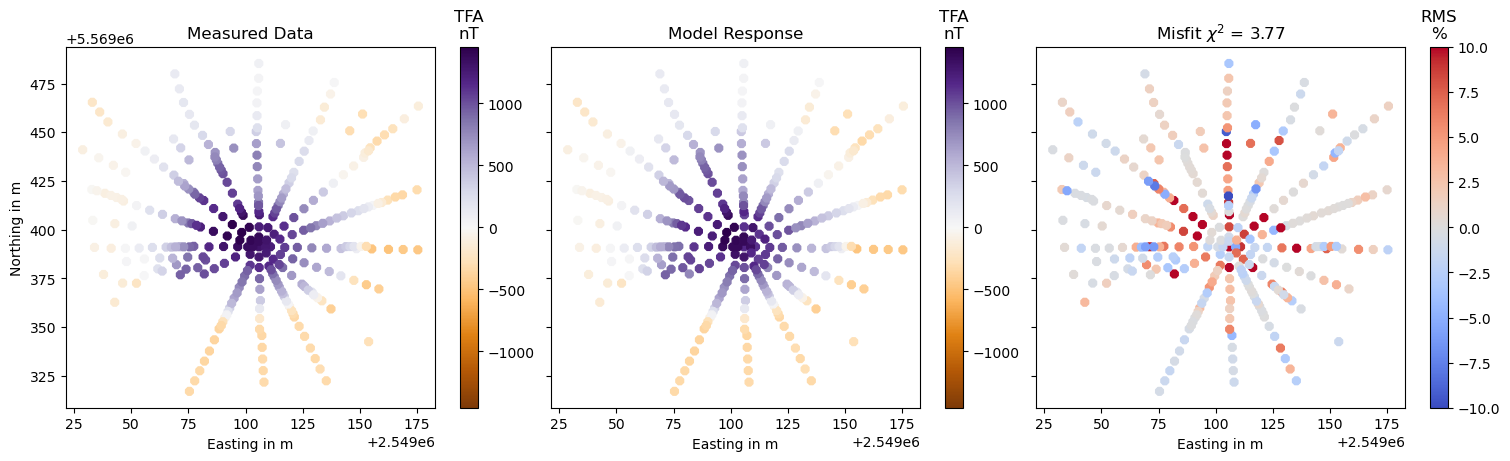

In [13]:
# Show result
fig, ax = showMagResult(pnts, MAG.inv)
plt.savefig(fig_dir+'MAG_conv_overview.pdf', dpi=600, bbox_inches='tight')

# Get response and misfit and model
d_pre = np.array(MAG.inv.response,dtype=float) # Predicted data in numpy array
mag_misfit = 100*(d_obs-d_pre)/d_obs          # Misfit in %
sus = np.array(MAG.inv.model,dtype=float)  # Magnetic susceptibility

# Save model and misfit
np.save(fn_dir+'Res_Conventional/misfit_mag_con', mag_misfit)
np.save(fn_dir+'Res_Conventional/sus_con', sus)

### ERT 2D inversions

In [7]:
ERT1 = ert.ERTManager(d_ert2d1)
ERT2 = ert.ERTManager(d_ert2d2)
ERT3 = ert.ERTManager(d_ert2d3)
ERT4 = ert.ERTManager(d_ert2d4)
r_est1_2d = ERT1.invert(d_ert2d1, lam=10, verbose=True, paraMaxCellSize=2, paraDepth=40, quality=33.6)
r_est2_2d = ERT2.invert(d_ert2d2, lam=10, verbose=True, paraMaxCellSize=2, paraDepth=40, quality=33.6)
r_est3_2d = ERT3.invert(d_ert2d3, lam=10, verbose=True, paraMaxCellSize=2, paraDepth=40, quality=33.6)
r_est4_2d = ERT4.invert(d_ert2d4, lam=10, verbose=True, paraMaxCellSize=2, paraDepth=40, quality=33.6)

23/06/23 - 16:36:53 - pyGIMLi - INFO - Found 2 regions.
23/06/23 - 16:36:53 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
23/06/23 - 16:36:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
23/06/23 - 16:36:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
23/06/23 - 16:36:54 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 17929 Cells: 35464 Boundaries: 26794
23/06/23 - 16:36:55 - pyGIMLi - INFO - Use median(data values)=65.4857396426762
23/06/23 - 16:36:55 - pyGIMLi - INFO - Created startmodel from forward operator: 7311 [65.4857396426762,...,65.4857396426762]
23/06/23 - 16:36:55 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001968ECE34A0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001968ECE3590>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001968ECE3540>
min/max (data): 31.38/153
min/max (error): 3.01%/4.78%
min/max (start model): 65.49/65.49
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 0.91 (dPhi = 97.84%) lam: 10


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.91)                   #
################################################################################


23/06/23 - 16:41:37 - pyGIMLi - INFO - Found 2 regions.
23/06/23 - 16:41:37 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
23/06/23 - 16:41:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
23/06/23 - 16:41:37 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
23/06/23 - 16:41:38 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 17311 Cells: 34208 Boundaries: 25862
23/06/23 - 16:41:38 - pyGIMLi - INFO - Use median(data values)=67.8189843586117
23/06/23 - 16:41:38 - pyGIMLi - INFO - Created startmodel from forward operator: 7070 [67.8189843586117,...,67.8189843586117]
23/06/23 - 16:41:38 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001968ECE3770>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001968ECE38B0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001968ECE3810>
min/max (data): 18.44/452
min/max (error): 3.01%/4.91%
min/max (start model): 67.82/67.82
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1.55 (dPhi = 96.74%) lam: 10
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 0.38 (dPhi = 66.66%) lam: 10.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.38)                   #
################################################################################


23/06/23 - 16:47:25 - pyGIMLi - INFO - Found 2 regions.
23/06/23 - 16:47:25 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
23/06/23 - 16:47:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
23/06/23 - 16:47:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
23/06/23 - 16:47:26 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 16587 Cells: 32792 Boundaries: 24784
23/06/23 - 16:47:26 - pyGIMLi - INFO - Use median(data values)=62.759828186719545
23/06/23 - 16:47:26 - pyGIMLi - INFO - Created startmodel from forward operator: 6707 [62.759828186719545,...,62.759828186719545]
23/06/23 - 16:47:26 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001968ECE39A0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001968ECE3AE0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001968ECE3A40>
min/max (data): 30.05/146
min/max (error): 3.01%/16.42%
min/max (start model): 62.76/62.76
--------------------------------------------------------------------------------


23/06/23 - 16:50:42 - pyGIMLi - INFO - Found 2 regions.
23/06/23 - 16:50:42 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
23/06/23 - 16:50:42 - pyGIMLi - INFO - Creating forward mesh from region infos.


--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 0.39 (dPhi = 98.38%) lam: 10


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.39)                   #
################################################################################


23/06/23 - 16:50:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
23/06/23 - 16:50:43 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 14147 Cells: 27896 Boundaries: 21120
23/06/23 - 16:50:43 - pyGIMLi - INFO - Use median(data values)=76.9365793789022
23/06/23 - 16:50:43 - pyGIMLi - INFO - Created startmodel from forward operator: 5609 [76.9365793789022,...,76.9365793789022]
23/06/23 - 16:50:43 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001968ECE3BD0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001968ECE3D10>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001968ECE3C70>
min/max (data): 17.62/854
min/max (error): 3%/16.77%
min/max (start model): 76.94/76.94
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 0.94 (dPhi = 98.59%) lam: 10


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.94)                   #
################################################################################


Text(0.5, 1.0, 'Misfit in %')

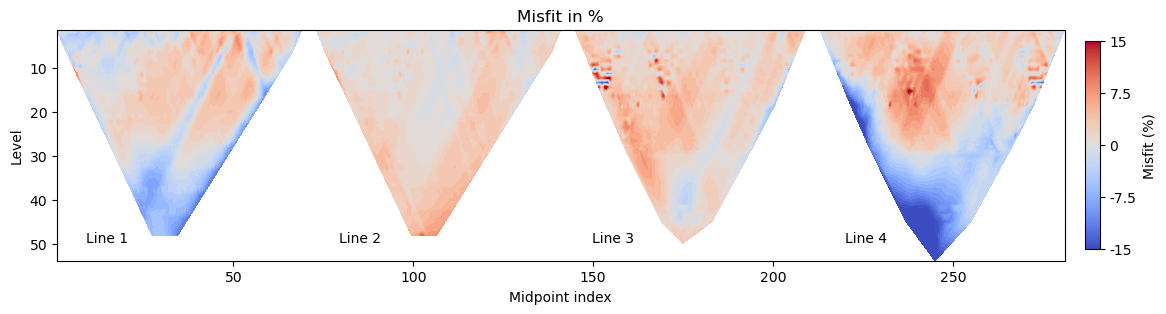

In [11]:
# Save 2D meshes for comparison
m2d1 = ERT1.paraDomain
m2d1.save(fn_dir+'mesh_2d1')

m2d2 = ERT2.paraDomain
m2d2.save(fn_dir+'mesh_2d2')

m2d3 = ERT3.paraDomain
m2d3.save(fn_dir+'mesh_2d3')

m2d4 = ERT4.paraDomain
m2d4.save(fn_dir+'mesh_2d4')

# Save resistivity model
np.save(fn_dir+'Res_Conventional/res_2d1', ERT1.model)
np.save(fn_dir+'Res_Conventional/res_2d2', ERT2.model)
np.save(fn_dir+'Res_Conventional/res_2d3', ERT3.model)
np.save(fn_dir+'Res_Conventional/res_2d4', ERT4.model)

# Save misfit
resp_2d = ERT1.inv.response.array().tolist() + ERT2.inv.response.array().tolist() + ERT3.inv.response.array().tolist() + ERT4.inv.response.array().tolist()
misfit_2d =  100*(d_ert['rhoa'].array()-np.array(resp_2d))/d_ert['rhoa'].array()
np.save(fn_dir+'Res_Conventional/misfit_2d', misfit_2d)

fig, ax = plt.subplots(1,figsize=(13, 3))
showPseudosections(d_ert, misfit_2d, idx_list, 4, ax=ax, clim=[-15, 15], cmap='coolwarm', Type='misfit')
ax.set_title('Misfit in %')
# plt.savefig(fig_dir+'ERT_2023_2D_Fit', dpi=600, bbox_inches='tight')

Text(0.5, 102.72222222222219, 'X (m)')

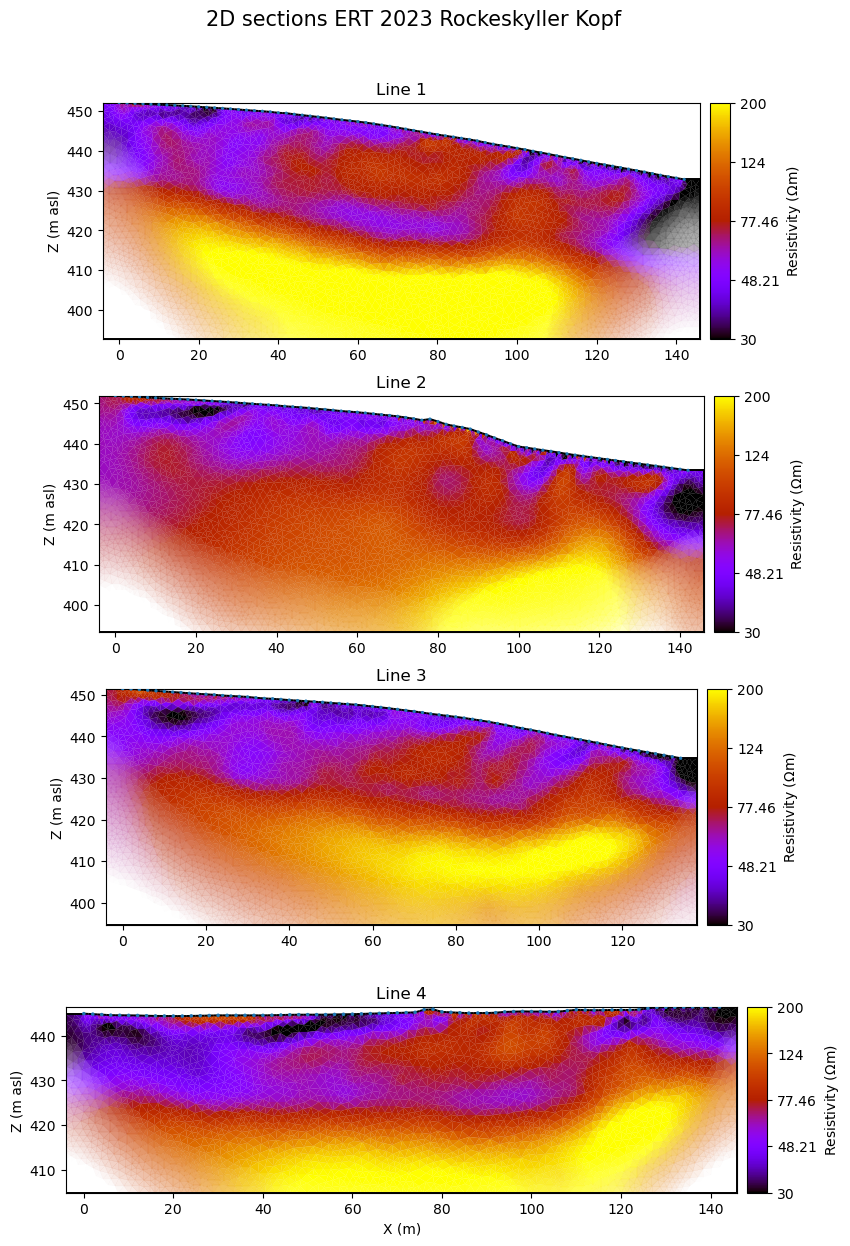

In [13]:
# Pot 2D sections
cmin = 30
cmax = 200
cmap = 'gnuplot'

fig, ax = plt.subplots(4,1, figsize=(8,12))
fig.tight_layout(pad=2)
ERT1.showResult(ax=ax[0],cMin=cmin, cMax=cmax,cMap=cmap, orientation='vertical')
ERT2.showResult(ax=ax[1],cMin=cmin, cMax=cmax,cMap=cmap, orientation='vertical')
ERT3.showResult(ax=ax[2],cMin=cmin, cMax=cmax,cMap=cmap, orientation='vertical')
ERT4.showResult(ax=ax[3],cMin=cmin, cMax=cmax,cMap=cmap, orientation='vertical')
ax[0].set_title('Line 1')
ax[1].set_title('Line 2')
ax[2].set_title('Line 3')
ax[3].set_title('Line 4')
fig.suptitle('2D sections ERT 2023 Rockeskyller Kopf', 
             x=.25, y=1.05, horizontalalignment='left', verticalalignment='top', fontsize = 15)

ax[0].set_ylabel('Z (m asl)')
ax[1].set_ylabel('Z (m asl)')
ax[2].set_ylabel('Z (m asl)')
ax[3].set_ylabel('Z (m asl)')
ax[3].set_xlabel('X (m)')

# plt.savefig('ERT_2023_2D_Sections', dpi=600, bbox_inches='tight')

### ERT 3D inversion

In [ ]:
ERT = ert.ERTManager(d_ert)

ERT.inv.setRegularization(limits=[1, 1e5])

start_ert = datetime.now()
ERT.invert(mesh=mesh, verbose=True, lam=15, dPhi=0.1)
print(f'ERT Inversion took: {datetime.now()-start_ert}')

14/06/23 - 12:51:23 - pyGIMLi - INFO - Found 1 regions.
14/06/23 - 12:51:23 - pyGIMLi - INFO - Creating forward mesh from region infos.


In [ ]:
# Save in Model and mesh
np.save(fn_dir+'Res_Conventional/res_con', ERT.model)

misfit_3d =  100*(d_ert['rhoa'].array()-ERT.inv.response.array())/d_ert['rhoa'].array()
np.save(fn_dir+'Res_Conventional/misfit_ert_con', misfit_3d)

fig, ax = plt.subplots(1,figsize=(13, 3))
showPseudosections(d_ert, misfit_3d, idx_list, 4, ax=ax, clim=[-15, 15], cmap='coolwarm', Type='misfit')
ax.set_title('Misfit in %')

## Plot Inversion Models

In [ ]:
%matplotlib widget

In [ ]:
p_list = [p1,p2,p3,p4]
m_list = [m2d1,m2d2,m2d3,m2d4]

res_int = interpolate3D_to_2DSection(m_list, p_list, mesh, ERT.model)
sus_int = interpolate3D_to_2DSection(m_list, p_list, mesh, sus)

In [ ]:
j = 3

c_ert = 'gnuplot'
c_mag = cmr.tropical
fig, ax = plt.subplots(2, sharex=True)
pg.show(m_list[j], res_int[j], cMap=c_ert, cMin=10, cMax=500, ax=ax[0], orientation='vertical', label=pg.unit('res'), logScale=True)
ax[0].set_ylim([408,455])
ax[0].set_title('ERT')
pg.show(m_list[j], sus_int[j], cMap=c_mag, cMin=0, cMax=0.15, ax=ax[1], orientation='vertical', label='Magnetic susceptibility', logScale=False)
ax[1].set_ylim([408,455])
ax[1].set_title('MAG')